Importing the libraries

In [49]:
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

In [50]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

Reading the dataset

In [51]:
dataset_ps = spark.read.csv('gs://finalproj-bucket/notebooks/jupyter/BigData_DS.csv', header=True, inferSchema=True)

In [95]:
dataset_ps.select('LV ActivePower (kW)').show(5)

+-------------------+
|LV ActivePower (kW)|
+-------------------+
|   380.047790527343|
|    453.76919555664|
|   306.376586914062|
|   419.645904541015|
|   380.650695800781|
+-------------------+
only showing top 5 rows



In [96]:
dataset_ps.select('LV ActivePower (kW)').count()

47033

Converting all the column names into lower case letters for our flexibility

In [53]:
dataset_ps = dataset_ps.toDF(*[c.lower() for c in dataset_ps.columns])

Extracting a substring from columns to create month and hour variables

In [54]:
from pyspark.sql.functions import substring
dataset_ps = dataset_ps.withColumn("month", substring("date/time", 4,2))
dataset_ps = dataset_ps.withColumn("hour", substring("date/time", 12,2))

In [55]:
from pyspark.sql.types import IntegerType
dataset_ps = dataset_ps.withColumn('month', dataset_ps.month.cast(IntegerType()))
dataset_ps = dataset_ps.withColumn('hour', dataset_ps.hour.cast(IntegerType()))
dataset_ps.show(5)

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

Extracting a random sample from the loaded original data set

In [56]:
dataset_s = dataset_ps.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

Calculating and visualizing the average production per month

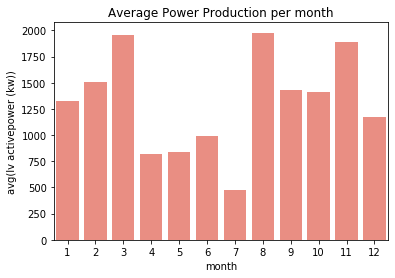

In [57]:
monthly = dataset_ps.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', color="salmon", data=monthly)
plt.title('Average Power Production per month');

Calculating and visualizing the average producion per hour

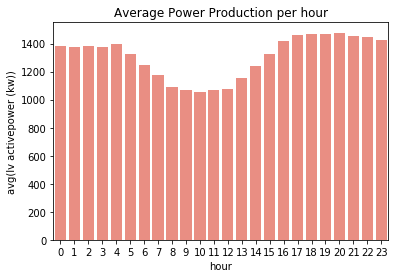

In [58]:
hourly = dataset_ps.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', color="salmon", data=hourly)
plt.title('Average Power Production per hour');

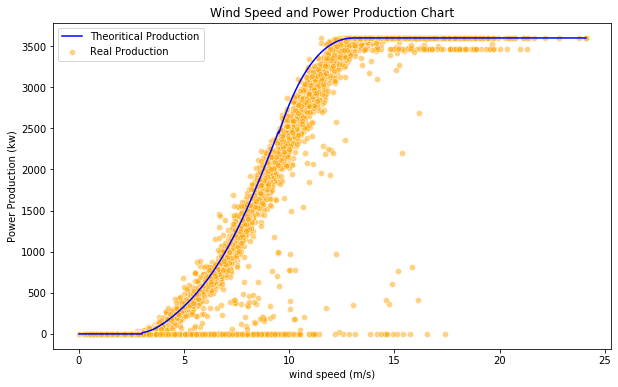

In [59]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=dataset_s)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=dataset_s)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

Filter the big data where the real and theoritical power productions are equal to 0

In [60]:
power_zero = dataset_ps.filter((dataset_ps['lv activepower (kw)'] == 0)
                                  & (dataset_ps['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(power_zero[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
3233,1.906574,0.0,0.0
3981,0.968506,0.0,0.0
2028,2.631503,0.0,0.0
3464,1.179039,0.0,0.0
884,2.569654,0.0,0.0


Checking the wind speed distribution for 0 power production

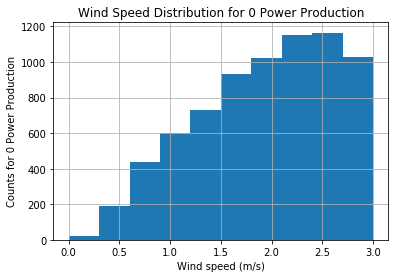

In [61]:
power_zero['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

Observations for the wind speed > 3m/s and power production = 0, While theoritically there should be power production

In [62]:
zero_power = dataset_ps.filter((dataset_ps['lv activepower (kw)'] == 0)
                            & (dataset_ps['theoretical_power_curve (kwh)'] != 0)
                            & (dataset_ps['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour
0,03 01 2018 15:40,0.0,3.743307,83.986265,245.068207,1,15
1,03 01 2018 16:40,0.0,3.034003,17.180593,221.086502,1,16
2,03 01 2018 16:50,0.0,3.197354,25.431221,232.679596,1,16
3,03 01 2018 17:00,0.0,3.907811,110.979604,241.973099,1,17
4,04 01 2018 13:50,0.0,3.441704,45.742725,79.094109,1,13


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


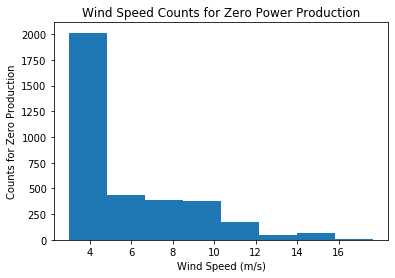

In [63]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

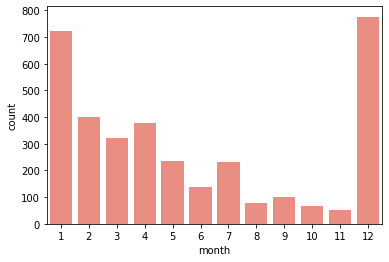

In [64]:
sns.countplot(zero_power['month'],color="salmon");

Excluding the observations meeting the filter criterias 

In [65]:
dataset_ps = dataset_ps.filter(~((dataset_ps['lv activepower (kw)'] == 0)
                            & (dataset_ps['theoretical_power_curve (kwh)'] != 0)
                            & (dataset_ps['wind speed (m/s)'] > 3)))

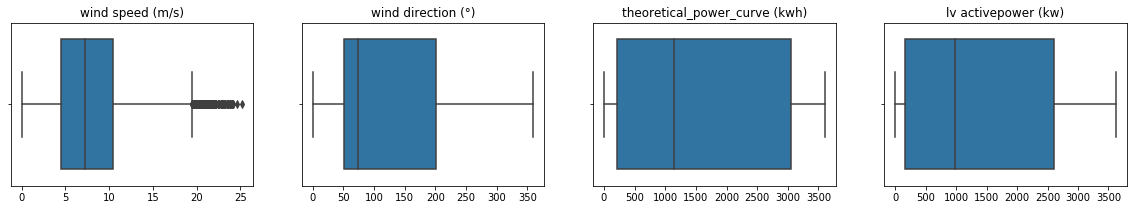

In [66]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(20,3))
for each in columns:
    df = dataset_ps.select(each).toPandas()
    plt.subplot(1,4,i)
    sns.boxplot(df)
    plt.title(each)
    i += 1

Creating a pandas data frame to build visualization

In [67]:
speed_w = dataset_ps.select('wind speed (m/s)').toPandas()

Defining the quantiles and interquantile range

In [68]:
Q1 = speed_w['wind speed (m/s)'].quantile(0.25)
Q3 = speed_w['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1

Defining the lower and upper threshold values

In [69]:
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [70]:
print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


Fancy indexing for outliers

In [71]:
outlier_tf = (speed_w['wind speed (m/s)'] < lower) | (speed_w['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(speed_w['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(speed_w['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
6994     20.087469
3246     20.781210
3257     19.993780
3519     24.083651
9264     21.980080
42811    19.513330
2105     19.581591
7451     20.714630
2120     20.125500
42816    19.914631
Name: wind speed (m/s), dtype: float64


In [72]:
dataset_ps.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(dataset_ps['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



In [73]:
from pyspark.sql import functions as F
dataset_ps = dataset_ps.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
dataset_ps.count()

47033

High level power production

In [74]:
dataset_ps.filter(((dataset_ps['month'] == 3) | (dataset_ps['month'] == 8) | (dataset_ps['month'] == 11)) 
                & ((dataset_ps['hour'] >= 16) | (dataset_ps['hour'] <= 24)) 
                & ((dataset_ps['wind direction (°)'] > 0) | (dataset_ps['wind direction (°)'] < 90))
                & ((dataset_ps['wind direction (°)'] > 180) | (dataset_ps['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757880403|
+------------------------+



Low level power production

In [75]:
dataset_ps.filter((dataset_ps['month'] == 7) 
                & ((dataset_ps['hour'] >= 9) | (dataset_ps['hour'] <= 11)) 
                & ((dataset_ps['wind direction (°)'] > 90) | (dataset_ps['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



Preparing the independent variables (Features)

In [76]:
from pyspark.ml.feature import VectorAssembler

Converting lv activepower (kw) variable as label

In [77]:
dataset_ps = dataset_ps.withColumn('label', dataset_ps['lv activepower (kw)'])

Defining the variables to be used

In [78]:
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(dataset_ps)

Combining features and label column

In [79]:
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



In [80]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37524
Test dataset :  9509


In [81]:
from pyspark.ml.regression import GBTRegressor

Creating the gbm regressor object

In [82]:
gbm = GBTRegressor(featuresCol='features', labelCol='label')

Training the model with train data

In [83]:
gbm_model = gbm.fit(train_df)

Predicting using the test data

In [84]:
y_pred = gbm_model.transform(test_df)

Initial look at the target and predicted values

In [85]:
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|13.387927332135007|
|355.225006103515| 357.0655718507231|
|380.650695800781| 431.1084842694825|
|402.391998291015| 431.1084842694825|
|750.551025390625| 752.2313718716772|
|874.722473144531| 933.1800780544065|
|968.499084472656| 921.6075614155574|
|1183.02099609375|1015.2505356738064|
|802.475280761718| 745.3636741934586|
|2331.07495117187|2365.0006200313155|
|2455.43310546875|2365.0006200313155|
|3155.94311523437|3229.5344108826716|
|966.777099609375|3374.8482860202257|
|3603.46899414062|3374.8482860202257|
|3536.75903320312|3374.8482860202257|
|3601.23095703125|3392.4254775071695|
|331.209503173828| 676.0343404137084|
|3593.00708007812|3483.1672170238594|
|     417.4453125| 691.9384795479592|
|    3603.7890625| 3494.316683804052|
+----------------+------------------+
only showing top 20 rows



Initial model success

In [86]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9805332873514738
MAE      :  82.73923755229143
RMSE     :  181.80559454524257


Converting dataset_s back to Spark dataframe

In [87]:
eva_df = spark.createDataFrame(dataset_s)

Converting lv activepower (kw) variable as label

In [88]:
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

Defining the variables to be used

In [89]:
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

Combining features and label column

In [90]:
vec_df = vec_df.select('features', 'label')

Using ML model to predict

In [91]:
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

Compining dataframes to compare

In [92]:
frames = [dataset_s[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

Visualizing real, theoritical and predicted power production

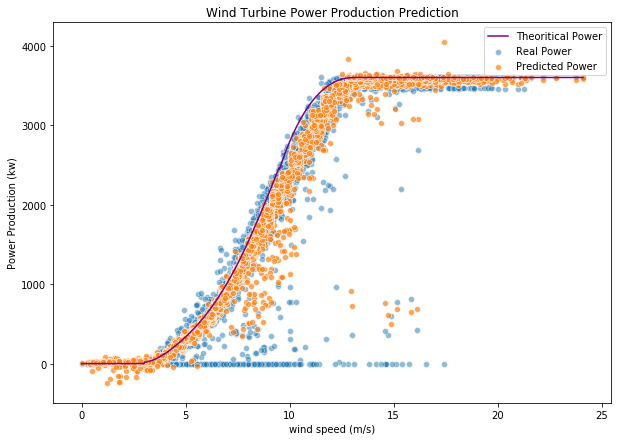

In [93]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();